In [1]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import sys

import torch
from torch import nn
from torch import optim
import sys
import itertools

from nf.conditional_prior import ConditionalDiagonalNormal
from nf.nets import MLP

from nf.flows import NormalizingFlow, NormalizingFlowModel, Invertible1x1Conv, ActNorm
from nf.spline_flows import NSF_CL

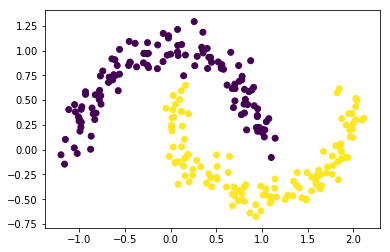

In [2]:
x, y = datasets.make_moons(256, noise=.1)
plt.scatter(x[:, 0], x[:, 1], c=y);

y.shape

y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

num_layers = 5
base_dist = ConditionalDiagonalNormal(shape=[2], 
                                      context_encoder=nn.Linear(1, 2*2))

In [3]:
dim = x.shape[-1]

nfs_flow = NSF_CL
flows = [nfs_flow(dim=dim, context_features=1, K=8, B=3, hidden_dim=128) for _ in range(3)]
convs = [Invertible1x1Conv(dim=dim) for _ in flows]
norms = [ActNorm(dim=dim) for _  in flows]
flows = list(itertools.chain(*zip(norms, convs, flows)))

# construct the model
model = NormalizingFlowModel(base_dist, flows)

/Users/ioanaciuca/anaconda3/envs/moreDL/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/RangeFactories.cpp:23.)


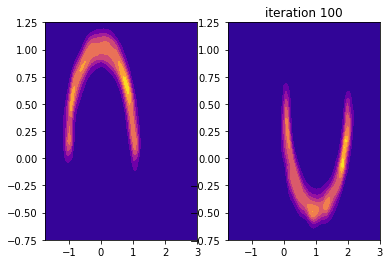

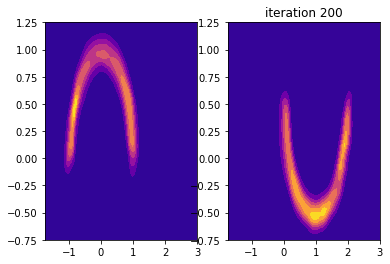

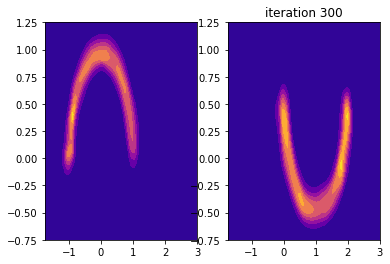

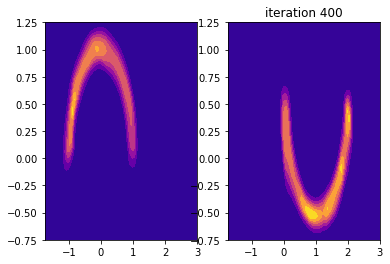

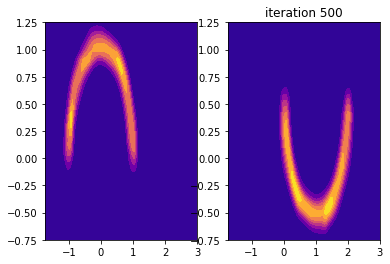

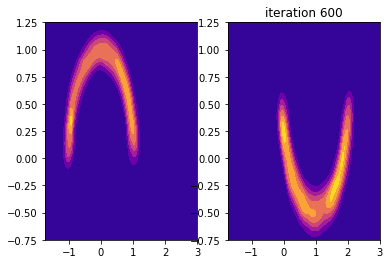

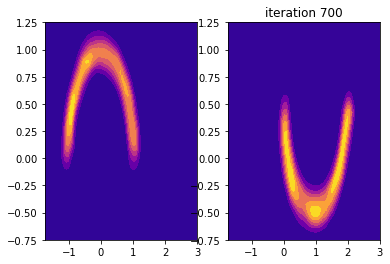

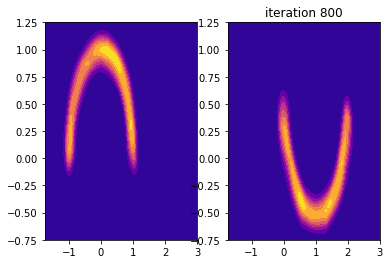

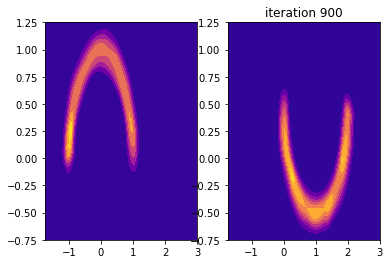

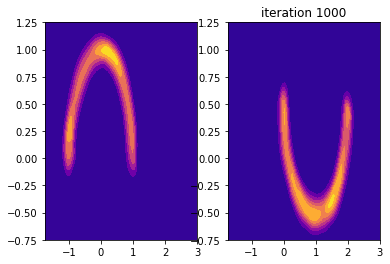

In [4]:
optimizer = optim.Adam(model.parameters())

num_iter = 1000
for i in range(num_iter):
    x, y = datasets.make_moons(128, noise=.1)
    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
    optimizer.zero_grad()
    zs, prior_logprob, log_det = model(x, context=y)
    logprob = prior_logprob + log_det
    loss = -torch.mean(logprob) # NLL
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 100 == 0:
        fig, ax = plt.subplots(1, 2)
        xline = torch.linspace(-1.75, 3)
        yline = torch.linspace(-.75, 1.25)
        xgrid, ygrid = torch.meshgrid(xline, yline)
        xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

        with torch.no_grad():
            z0, prior_logprob0, log_det0 = model(xyinput, torch.zeros(10000, 1))
            logprob0 = (prior_logprob0 + log_det0).exp().reshape(100, 100)
            z1, prior_logprob1, log_det1 = model(xyinput, torch.ones(10000, 1))
            logprob1 = (prior_logprob1 + log_det1).exp().reshape(100, 100)
            
        ax[0].contourf(xgrid.numpy(), ygrid.numpy(), logprob0.numpy(), cmap='plasma')
        ax[1].contourf(xgrid.numpy(), ygrid.numpy(), logprob1.numpy(), cmap='plasma')
        plt.title('iteration {}'.format(i + 1))
        plt.savefig('test.png')
        plt.show()
        
torch.save(model.state_dict(), f'model.pth')